In [ ]:
# mount git hub repo
!git clone https://github.com/gamma-opt/icnn.git


Cloning into 'icnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 117.99 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
# install julia
%%shell
set -e
wget -nv https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh -O /tmp/install_colab.sh
bash /tmp/install_colab.sh  # Takes ~ 2 minutes

2024-11-21 14:52:17 URL:https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh [1058/1058] -> "/tmp/install_colab.sh" [1]
Installing Julia 1.10.5 on the current Colab Runtime...
2024-11-21 14:52:19 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.5-linux-x86_64.tar.gz [173909866/173909866] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


Now,
- go to the "Runtime" tab
- select "Change runtime type"
- select julia in the "Runtime type" dropdown
- click "save"

You might need to refresh the page.


In [1]:
import Pkg
Pkg.add("Gogeta")
Pkg.add("JuMP")
Pkg.add("Plots")
Pkg.add("JSON")
Pkg.add("Alpine")
Pkg.add("HiGHS")
Pkg.add("Juniper")
Pkg.add("Ipopt")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ScientificTypesBase ───────── v3.0.0
   Installed GPUArraysCore ─────────────── v0.2.0
   Installed RealDot ───────────────────── v0.1.0
   Installed IrrationalConstants ───────── v0.2.2
   Installed IRTools ───────────────────── v0.4.14
   Installed Transducers ───────────────── v0.4.84
   Installed MutableArithmetics ────────── v1.6.0
   Installed Adapt ─────────────────────── v4.1.1
   Installed DiffRules ─────────────────── v1.15.1
   Installed Functors ──────────────────── v0.4.12
   Installed ContextVariablesX ─────────── v0.1.3
   Installed HypergeometricFunctions ───── v0.3.25
   Installed ShowCases ─────────────────── v0.1.0
   Installed ArgCheck ──────────────────── v2.4.0
   Installed MLJModelInterface ─────────── v1.11.0
   Installed StatsFuns ─────────────────── v1.3.2
   Installed Flux ──────────────────────── v0.14.25
   Installed FLoopsBase ────────────────── v0.1.1

In [2]:
using Pkg
Pkg.add("IJulia")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [4]:
using Gogeta
using JuMP
using Plots
using JSON
using Alpine
using HiGHS
using Juniper
using Ipopt
using IJulia

# replace with the path to the model_weights.json file
filepath = "icnn/model_weights_3D.json"

# Read the JSON file
json_content = read(filepath, String)

# Parse the JSON content
parsed_json = JSON.parse(json_content)

Dict{String, Any} with 3 entries:
  "FC2"   => Any[Any[Any[0.930625], Any[0.910696], Any[1.24932], Any[0.745088]], Any[-0.376794]]
  "SKIP2" => Any[Any[Any[0.980311], Any[1.031]]]
  "FC1"   => Any[Any[Any[-1.02581, -0.362694, 0.285553, -1.45823], Any[-0.36712, -1.1315, -0.835101…

In [5]:
#-----------------------------ICNN-------------------------------------------------#

# Configure Ipopt to be silent
nlp_solver = optimizer_with_attributes(
    Ipopt.Optimizer,
    "print_level" => 0
)

# Configure Juniper to be silent
juniper_solver = optimizer_with_attributes(
    Juniper.Optimizer,
    "nl_solver" => nlp_solver,
    "log_levels" => []
)

# Configure HiGHS to be silent
milp_solver = optimizer_with_attributes(
    HiGHS.Optimizer,
    "output_flag" => false
)

# Create the Alpine optimizer with silent logging
alpine_optimizer = optimizer_with_attributes(
    Alpine.Optimizer,
    "nlp_solver" => juniper_solver,
    "mip_solver" => milp_solver,
    "log_level" => 0  # Ensure Alpine's logging is silent
)

# define the icnn model
icnn_lp =  Model(alpine_optimizer)

# define the output variable
icnn_output_var = @variable(icnn_lp, z, base_name="output_var")

# define the input variable
icnn_input_var_1 = @variable(icnn_lp, x1, base_name="input_var_1")

# define the input variable
icnn_input_var_2 = @variable(icnn_lp, x2, base_name="input_var_2")

# define the objective function
@objective(icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(icnn_lp, x1 <= 1)
@constraint(icnn_lp, x1 >= -1)
# define the constraints on input variable
@constraint(icnn_lp, x2 <= 1)
@constraint(icnn_lp, x2 >= -1)


# add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(icnn_lp, filepath, icnn_output_var, icnn_input_var_1, icnn_input_var_2)

function forwardpass(jump_model, input_values)
    fix(icnn_lp[:x1], input_values[1]; force = true)
    fix(icnn_lp[:x2], input_values[2]; force = true)
    optimize!(jump_model)
    return value.(jump_model[:z])
end



forwardpass (generic function with 1 method)

In [6]:
#---------------------------Out ICNN-----------------------------------------------#
# define the outter jump model
out_icnn_lp = Model(alpine_optimizer)

# define the output variable
out_output_var = @variable(out_icnn_lp, z, base_name="output_var")

# define the input variable
out_input_var_1 = @variable( out_icnn_lp, x1, base_name="input_var_1")

# define the input variable
out_input_var_2 = @variable( out_icnn_lp, x2, base_name="input_var_2")


# define the objective
@objective(out_icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(out_icnn_lp, x1 <= 1)
@constraint(out_icnn_lp, x1 >= -1)
# define the constraints on input variable
@constraint(out_icnn_lp, x2 <= 1)
@constraint(out_icnn_lp, x2 >= -1)



input_var_2 ≥ -1

In [7]:
#---------------------------Example 1----------------------------------------------#

# add contraint on the output variable
@constraint(out_icnn_lp, exm_1, z >= 0.5)

# define the objective
@objective(out_icnn_lp, Min, 0)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var_1, out_input_var_2)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x1_optimal = value.(out_icnn_lp[:x1])
x2_optimal = value.(out_icnn_lp[:x2])
out_z_optimal = value.(out_icnn_lp[:z])

icnn_z_optimal = forwardpass(icnn_lp, [x1_optimal, x2_optimal])

# Define the function f(x) = x1^2+x2^2
f(x1,x2) = x1^2+x2^2


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


f (generic function with 1 method)

In [8]:
println(out_icnn_lp)

Min output_var
Subject to
 -input_var_1 + _[4] = 0
 -input_var_2 + _[5] = 0
 output_var - _[10] = 0
 input_var_1 ≥ -1
 input_var_2 ≥ -1
 exm_1 : output_var ≥ 0.5
 _[6] ≥ 0
 _[7] ≥ 0
 _[8] ≥ 0
 _[9] ≥ 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] ≥ -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] ≥ -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] ≥ -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] ≥ -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] ≥ -0.37679436802864075
 input_var_1 ≤ 1
 input_var_2 ≤ 1



In [9]:
using Base.Iterators: product

# Generate data for plotting
x1_values = collect(-1:0.1:1)
x2_values = collect(-1:0.1:1)

# Create all combinations of x1 and x2
input_pairs = collect(product(x1_values, x2_values))

# Convert tuples to arrays if needed
input_pairs = [ [x, y] for (x, y) in input_pairs ]

# Initialize output array
icnn_outputs = zeros(length(input_pairs))

# Loop over input pairs
for i in 1:length(input_pairs)
    icnn_outputs[i] = forwardpass(icnn_lp, input_pairs[i])
end

# Create a hyperplane z = 0.5
Z_plane = 0.5 * ones(length(input_pairs))



*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

441-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 ⋮
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528


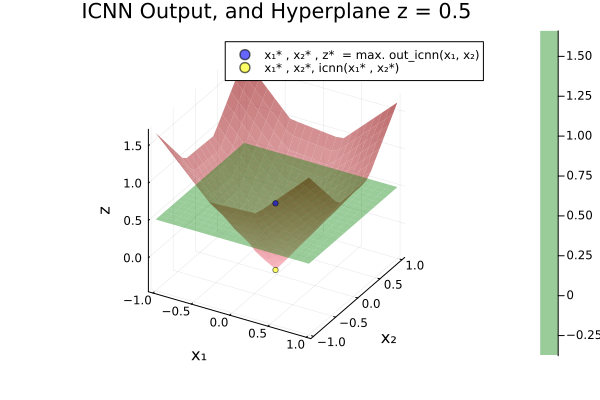

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:528


In [17]:
# Select a backend (optional)
gr()

# Plot the  ICNN surface
plt = surface(
    x1_values, x2_values, icnn_outputs,
    xlabel = "x₁",
    ylabel = "x₂",
    zlabel = "z",
    title = "ICNN Output, and Hyperplane z = 0.5",
    color = :reds,
    opacity = 0.6,
    label = "ICNN Output Surface"
)


# Add the hyperplane to the plot
surface!(
    x1_values, x2_values, Z_plane,
    color = :green,
    opacity = 0.4,
    label = "z = 0.5 Hyperplane"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [out_z_optimal],
    color = :blue,
    markerstrokecolor = :black,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂* , z*  = max. out_icnn(x₁, x₂)"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [icnn_z_optimal],
    color = :yellow,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂*, icnn(x₁* , x₂*) "
)

# Add legend and adjust the camera angle
plot!(
    legend = :topright,
)


# Display the plot
display(plt)


In [ ]:
#---------------------------Example 2---------------------------------------------#

delete(out_icnn_lp, exm_1)

# define the objective
@objective(out_icnn_lp, Max, x+z)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x_optimal = value.(out_icnn_lp[:x])
out_z_optimal = value.(out_icnn_lp[:z])


*** Alpine ended with status OPTIMAL ***


168055.6667133


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

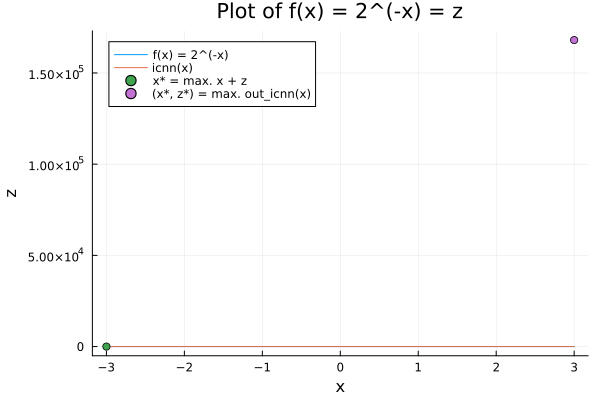

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

#forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# calculate x+z values
xz = x_values .+ icnn

max_ind = findfirst(x -> x == maximum(xz), xz)
scatter!([x_values[max_ind]], [icnn[max_ind]], label="x* = max. x + z")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")